In [9]:
from tifffile import imread, imwrite
from skimage import filters, measure, feature, morphology, segmentation
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
fpath = 'Z:/Data/Processed/2022-09-12-Rena-HeLa16Gene/output/2022-09-22-2D-max-projection'
areas = range(1,8)

## 2D segmentation

In [58]:
# params
sigma = 6
nucleus_min_size = 100
nucleus_max_size = 40000

In [22]:
for im in areas:
    # nucleus
    dapi = imread(os.path.join(fpath, f'Area{im}_dapi_2d.tif'))
    dapi_gf = filters.gaussian(dapi, sigma=sigma)
    dapi_mf = filters.median(dapi_gf)
    thresh = filters.threshold_li(dapi_mf)
    binary = dapi_mf >= thresh
    nuclei = measure.label(binary)
    

    # # cytosol
    # flamingo = imread(os.path.join(fpath, f'Area{im}_flamingo_2d.tif'))
    break

### test

In [4]:
dapi = imread(os.path.join(fpath, 'Area1_dapi_2d.tif'))
dapi_gf = filters.gaussian(dapi, sigma=6)
dapi_mf = filters.median(dapi_gf)
thresh = filters.threshold_li(dapi_mf)
binary = dapi_mf >= thresh

In [ ]:
filters.try_all_threshold(dapi_mf[:3000,:3000], figsize=(30,30))

label connected components

In [91]:
nuclei = measure.label(binary)
example_large = nuclei[:3000,:3000][1900,500]
np.count_nonzero(nuclei==example_large)

93846

In [42]:
# np.max(nuclei)
# for obj in range(1, np.max(nuclei)+1): # alt: regionprops
#     if np.count_nonzero(nuclei==obj) < nucleus_min_size or np.count_nonzero(nuclei==obj) > nucleus_max_size:
#         nuclei[nuclei==obj] = 0
# NOTE slower

In [99]:
nuclei = measure.label(binary)
rp = measure.regionprops(nuclei)
for obj in rp: # alt: regionprops
    if obj.area < 1000 or obj.area > 80000:
        nuclei[nuclei==obj.label] = 0

<AxesSubplot:ylabel='Count'>

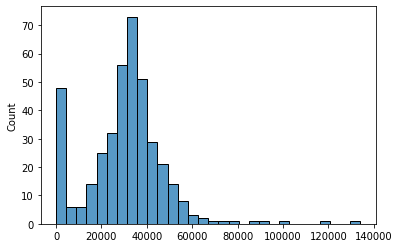

In [82]:
sns.histplot([r.area for r in rp])

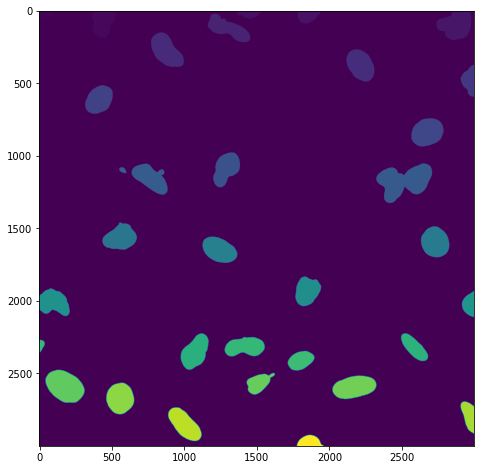

In [100]:
fig = plt.figure(figsize=(8,8))
# plt.imshow(dapi[:3000,:3000])
# plt.imshow(dapi_gf[:3000,:3000])
# plt.imshow(dapi_mf[:3000,:3000])
# plt.imshow(binary[:3000,:3000], cmap='gray')
plt.imshow(nuclei[:3000,:3000])
# plt.imshow(nuclei)

watershed

In [39]:
from scipy import ndimage
distance = ndimage.distance_transform_edt(binary)
local_max = feature.peak_local_max(distance, min_distance=20)
im_local_max = np.zeros(shape=binary.shape)
for lm in local_max:
    im_local_max[lm[0],lm[1]] = True
markers = measure.label(im_local_max)
label_ws = segmentation.watershed(-distance, markers, mask=binary)

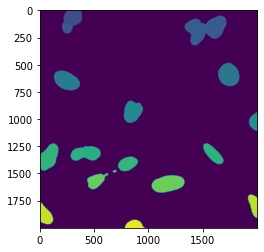

In [40]:
# plt.imshow(distance[:2000,:2000])
# plt.imshow(im_local_max[:2000,:2000])
# plt.imshow(markers[:2000,:2000])
plt.imshow(label_ws[1000:3000,1000:3000])

527

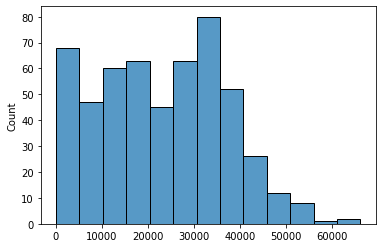

In [41]:
rp = measure.regionprops(label_ws)
sns.histplot([r.area for r in rp])
len(rp)

In [42]:
rp = measure.regionprops(label_ws)
for obj in rp: # alt: regionprops
    if obj.area < 1000 or obj.area > 80000:
        label_ws[label_ws==obj.label] = 0

In [43]:
np.unique(label_ws[1000:3000,1000:3000])

array([  0,  30,  35,  36,  38,  50,  53,  60,  64,  79,  80,  81,  82,
        83,  96,  97, 113, 115, 122, 125])

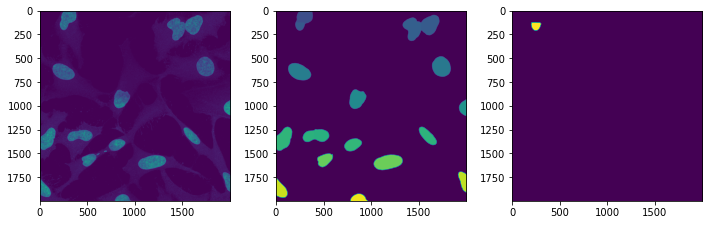

In [56]:
fig, ax = plt.subplots(1,3,figsize=(12,3.5))
ax[0].imshow(dapi[1000:3000,1000:3000])
ax[1].imshow(label_ws[1000:3000,1000:3000])
ax[2].imshow(label_ws[1000:3000,1000:3000]==35)

random walker

In [132]:
markers[~binary] = -1
labels_rw = segmentation.random_walker(binary, markers)

KeyboardInterrupt: 

In [60]:
# save a section for CellProfiler testing
dapi = imread(os.path.join(fpath, 'Area1_dapi_2d.tif'))
flamingo = imread(os.path.join(fpath, 'Area1_flamingo_2d.tif'))
dapi_test = dapi[:5000, :5000]
flamingo_test = flamingo[:5000, :5000]
imwrite(os.path.join(fpath, 'dapi_test.tif'), dapi_test)
imwrite(os.path.join(fpath, 'flamingo_test.tif'), flamingo_test)